# Hybrid Recommender System

Built a hybrid system that combines the content-based and collaborative filtering systems. The goal of the hybrid system is to combine the strengths of both systems and to reduce the issue of the cold start problem typical with collaborative filtering.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
ratings = pd.read_csv('ratings.csv')
users = pd.read_csv('tags.csv')
movies = pd.read_csv('movies.csv')

In [2]:
movies.tail()
movies['genres'] = movies['genres'].str.replace('|',' ')

In [3]:
len(movies.movieId.unique())

9125

In [4]:
len(ratings.movieId.unique())

9066

In [5]:
ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 55)

movie_list_rating = ratings_f.movieId.unique().tolist()

In [6]:
len(ratings_f.movieId.unique())/len(movies.movieId.unique()) * 100

98.37808219178082

In [7]:
len(ratings_f.userId.unique())/len(ratings.userId.unique()) * 100

59.31445603576751

In [8]:
movies = movies[movies.movieId.isin(movie_list_rating)]

In [9]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [11]:
users.drop(['timestamp'],1, inplace=True)
ratings_f.drop(['timestamp'],1, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
mixed = pd.merge(movies, users, on='movieId', how='left')
mixed.head()

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,501.0,Pixar
1,2,Jumanji (1995),Adventure Children Fantasy,NaN,NaN
2,3,Grumpier Old Men (1995),Comedy Romance,NaN,NaN
3,4,Waiting to Exhale (1995),Comedy Drama Romance,NaN,NaN
4,5,Father of the Bride Part II (1995),Comedy,431.0,steve martin


In [13]:
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(
                                          lambda x: "%s" % ' '.join(x)))
Final = pd.merge(movies, mixed, on='movieId', how='left')
Final ['metadata'] = Final[['tag', 'genres']].apply(
                                          lambda x: ' '.join(x), axis = 1)
Final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),Pixar Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())
print(tfidf_df.shape)

(8977, 698)


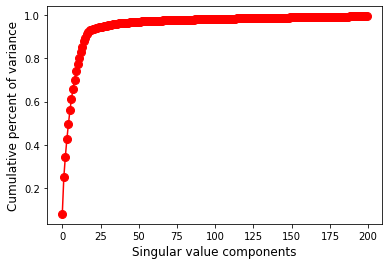

In [15]:
# SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(tfidf_df)
# plot variance explained
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [16]:
n = 25
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=Final.title.tolist())

In [17]:
latent_matrix.shape

(8977, 200)

In [18]:
ratings_f.head()

,userId,movieId,rating
20,2,10,4.0
21,2,17,5.0
22,2,39,5.0
23,2,47,4.0
24,2,50,4.0


In [19]:
ratings_f1 = pd.merge(movies[['movieId']], ratings_f, on="movieId", how="right")

In [20]:
ratings_f2 = ratings_f1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)

In [21]:
ratings_f2.head()

userId,2,4,5,7,8,12,15,17,19,20,...,655,656,658,659,660,662,664,665,667,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,3.0,3.5,...,0.0,0.0,0.0,0.0,2.5,0.0,3.5,0.0,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,...,4.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0
3,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0


In [22]:
len(ratings_f.movieId.unique())

8977

In [23]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=25)
latent_matrix_2 = svd.fit_transform(ratings_f2)
latent_matrix_2_df = pd.DataFrame(
                             latent_matrix_2,
                             index=Final.title.tolist())

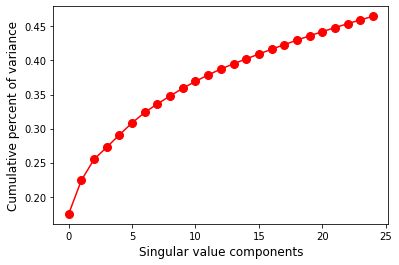

In [24]:
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
# take the latent vectors for a selected movie from both content 
# and collaborative matrixes
#you can enter any movie in the dataset and it will return 20 recommended movies from the hybrid system
a_1 = np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc['Toy Story (1995)']).reshape(1, -1)

# calculate the similarity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

# hybrid system is simply the average of content-based and collaborative filtering
hybrid = ((score_1 + score_2)/2.0)

# form a data frame of similar movies 
dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index )

#sort it by hybrid score
similar.sort_values('hybrid', ascending=False, inplace=True)

#Show the top 20 recommended movies based on hybrid system
similar[1:].head(20)

,content,collaborative,hybrid
Toy Story 2 (1999),0.943550,0.886100,0.914825
"Monsters, Inc. (2001)",0.999944,0.806116,0.903030
Shrek (2001),0.938482,0.812035,0.875259
"Bug's Life, A (1998)",0.876700,0.839319,0.858010
Antz (1998),0.999944,0.677087,0.838515
Finding Nemo (2003),0.876700,0.769022,0.822861
"Emperor's New Groove, The (2000)",0.999943,0.602875,0.801409
"Incredibles, The (2004)",0.808461,0.786288,0.797375
Aladdin (1992),0.741306,0.851433,0.796369
Ice Age (2002),0.876700,0.685525,0.781113


In [26]:
from sklearn.metrics.pairwise import cosine_similarity
# take the latent vectors for a selected movie from both content 
# and collaborative matrixes
a_1 = np.array(latent_matrix_1_df.loc['Finding Nemo (2003)']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc['Finding Nemo (2003)']).reshape(1, -1)

# calculate the similarity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

# hybrid system is simply the average of content-based and collaborative filtering
hybrid = ((score_1 + score_2)/2.0)

# form a data frame of similar movies 
dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index )

#sort it by hybrid score
similar.sort_values('hybrid', ascending=False, inplace=True)

#Show the top 10 recommended movies based on hybrid system
similar[1:].head(20)

,content,collaborative,hybrid
"Incredibles, The (2004)",0.922755,0.971351,0.947053
Ice Age (2002),1.000000,0.864287,0.932143
"Monsters, Inc. (2001)",0.876754,0.953315,0.915034
Shrek (2001),0.822872,0.943151,0.883012
Wallace & Gromit in The Curse of the Were-Rabbit (2005),1.000000,0.754046,0.877023
Shrek 2 (2004),0.798557,0.908388,0.853472
Chicken Run (2000),0.883482,0.817383,0.850432
Toy Story 2 (1999),0.881887,0.806009,0.843948
Ice Age 2: The Meltdown (2006),1.000000,0.687490,0.843745
"Bug's Life, A (1998)",1.000000,0.676353,0.838176


In [27]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

In [28]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_f[['userId','movieId','rating']], reader)

#train-test split: 75% train and 25% test
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

#RMSE on test set
accuracy.rmse(predictions)

RMSE: 0.8919


0.8919005785988012

In [29]:
def pred_user_rating(ui):
    if ui in ratings_f.userId.unique():
        ui_list = ratings_f[ratings_f.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = algorithm.predict(ui, j)
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movies', inplace=True)    
        return pdf.head(10)        
    else:
        print("User Id does not exist.")
        return None

In [30]:
user_id = 8
pred_user_rating(user_id)

,ratings
movies,
"African Queen, The (1951)",4.577881
"Godfather: Part II, The (1974)",4.506825
Cool Hand Luke (1967),4.462359
Rear Window (1954),4.417922
All About Eve (1950),4.387785
On the Waterfront (1954),4.384060
This Is Spinal Tap (1984),4.371518
One Flew Over the Cuckoo's Nest (1975),4.364163
Raging Bull (1980),4.360628


In [31]:
import joblib

In [33]:
joblib.dump(hybrid, 'model.joblib')

['model.joblib']